In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **1 Model performance**

**1.1 Dataset size vs model performance**

1. Split the train/test sets with 9:1 ratio This split should give you approximately 291k/32k
samples in train/test set, respectively.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
Data_Response = pd.read_csv('drive/MyDrive/CHE1147/A3/Retail_Data_Response.csv')

In [7]:
mth_rolling_features = pd.read_excel('drive/MyDrive/CHE1147/A3/mth_rolling_features.xlsx')
mth_rolling_features = mth_rolling_features.drop('Unnamed: 0', axis = 1)
mth_rolling_features = mth_rolling_features.fillna(0)

In [3]:
mth_day_counts = pd.read_excel('drive/MyDrive/CHE1147/A3/mth_day_counts.xlsx')
mth_day_counts = mth_day_counts.drop('Unnamed: 0', axis = 1)

In [4]:
day_since_last_txn = pd.read_excel('drive/MyDrive/CHE1147/A3/days_since_last_txn.xlsx')
day_since_last_txn = day_since_last_txn.drop('Unnamed: 0', axis = 1)

In [8]:
mth_features_merge = pd.merge(mth_rolling_features, mth_day_counts, on = ['CLNT_NO', 'ME_DT']).merge(day_since_last_txn, on = ['CLNT_NO', 'ME_DT']).merge(Data_Response.rename(columns={'customer_id': 'CLNT_NO'}), on = 'CLNT_NO')
mth_features_merge.head() 

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
0,CS1112,2011-05-31,0,0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,0,-1,0
1,CS1112,2011-06-30,56,1,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0,0,0,0,0,0,1,15,0
2,CS1112,2011-07-31,0,0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,46,0
3,CS1112,2011-08-31,96,1,152.0,50.666667,96.0,2.0,0.666667,1.0,...,0.0,1,0,0,0,0,0,0,12,0
4,CS1112,2011-09-30,0,0,96.0,32.000000,96.0,1.0,0.333333,1.0,...,0.0,0,0,0,0,0,0,0,42,0


In [9]:
y = mth_features_merge['response']
X = mth_features_merge.drop(['CLNT_NO', 'response', 'ME_DT'], axis = 1)

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

2. Initialize and create a for loop in which you take N samples (e.g. 50), build a tree
model with the N samples and evaluate the test set AUC. Repeat the sampling process
10 times and append the test set AUC. The following table shows the desired output:(table on PDF)

From this table, you can calculate the mean and standard deviation of the test AUC
for N samples.

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [14]:
def tree_model(N):
  test_auc = []
  for num in range(10):
      X_train_new = X_train.sample(n = N)
      x_index = X_train_new.index
      y_train_new = y_train[x_index]
      best_model = DecisionTreeClassifier(max_depth=10, random_state=0, class_weight='balanced') 
      best_model.fit(X_train_new, y_train_new)
      y_test_prob = best_model.predict_proba(X_test)[:,1]
      fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)
      test_auc.append(auc(fpr_test, tpr_test))
      test_auc_mean = np.mean(test_auc)
      test_auc_std = np.std(test_auc)
  return test_auc, test_auc_mean, test_auc_std

In [15]:
test_auc, test_auc_mean, test_auc_std = tree_model(50)
test_auc_table = {'sample': np.arange(1,11),'Test AUC': test_auc}
pd.DataFrame(test_auc_table).style.hide_index()

sample,Test AUC
1,0.513587
2,0.522975
3,0.504095
4,0.530986
5,0.513013
6,0.500944
7,0.501090
8,0.505036
9,0.499944
10,0.520264


In [16]:
test_auc_mean

0.5111934736824203

In [17]:
test_auc_std

0.010216752096612375

3. Repeat the procedure you performed in the previous step for different sample size N
(e.g. 100, 500, 1000, 2000, 5000, 10000) .

In [30]:
N = [100, 500, 1000, 2000, 5000, 7000, 10000, 15000, 20000, 50000, 70000, 100000]

In [31]:
data = {}
data['Mean'] = []
data['std'] = []
for i in N:
  test_auc, test_auc_mean, test_auc_std = tree_model(i)
  data['Mean'].append(test_auc_mean)
  data['std'].append(test_auc_std)

In [32]:
df3 = pd.DataFrame(data)

In [33]:
df3.index = N

4. Build a table that contains the values of:
❼ Sample size N
❼ Test AUC mean
❼ Test AUC standard deviation

In [34]:
df3

,Mean,std
100,0.507794,0.014838
500,0.508793,0.009094
1000,0.517779,0.020194
2000,0.526969,0.016815
5000,0.552797,0.013928
7000,0.552867,0.007594
10000,0.567288,0.011055
15000,0.579016,0.008768
20000,0.587558,0.004488
50000,0.612730,0.004986


5. Using the matplotlib function errorbar, plot the model performance captured in the
test AUC mean and standard deviation as a function of the sample size. From this
plot, can you estimate what is the minimum number of samples needed to model the
behaviour adequately?

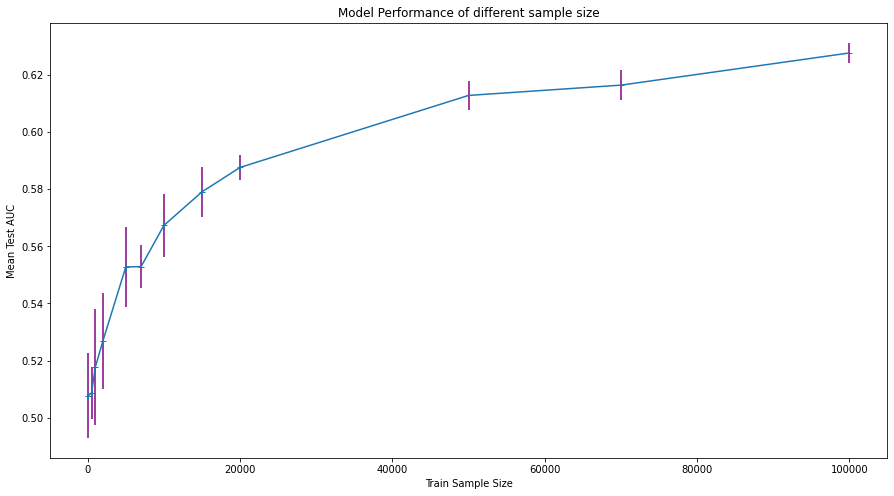

In [35]:
plt.figure(figsize=(15,8))
plt.errorbar(N, data['Mean'], yerr=data['std'],marker = '+', ecolor = 'purple') 
plt.title('Model Performance of different sample size')
plt.ylabel('Mean Test AUC')
plt.xlabel('Train Sample Size')
plt.show()

From the graph shown above, I can see the gradient before N = 20000 is large and become flat after that. And also the standard devision become smaller after N = 20000. Therefore if we want model behave adequately we need at least 20000 sample points.